## Dataset Download

In [1]:
import os
try:
    from google_drive_downloader import GoogleDriveDownloader as gdd
    print("import google_drive_downloader...!")
except ModuleNotFoundError:
    !pip install googledrivedownloader
    from google_drive_downloader import GoogleDriveDownloader as gdd
    print("import downloaded google_drive_downloader...!")
    
# Need to download the Omniglot dataset -- DON'T MODIFY THIS CELL
if not os.path.isdir('./omniglot_resized'):
    gdd.download_file_from_google_drive(file_id='1iaSFXIYC3AB8q9K_M-oVMa4pmB7yKMtI',
                                        dest_path='./omniglot_resized.zip',
                                        unzip=True)
    
assert os.path.isdir('./omniglot_resized')

# select GPU number!!
# os.environ["CUDA_VISIBLE_DEVICES"] = "1"

import google_drive_downloader...!


## Utility functions

In [2]:
""" Utility functions. """
## NOTE: You do not need to modify this block but you will need to use it.
import numpy as np
import os
import random
import tensorflow as tf

## Loss utilities
def cross_entropy_loss(pred, label, k_shot):
    return tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=tf.stop_gradient(label)) / k_shot)

def accuracy(labels, predictions):
    return tf.reduce_mean(tf.cast(tf.equal(labels, predictions), dtype=tf.float32))

## Convolutional layers used by MAML Model

In [3]:
"""Convolutional layers used by MAML model."""
## NOTE: You do not need to modify this block but you will need to use it.
seed = 123
def conv_block(inp, cweight, bweight, bn, activation=tf.nn.relu, residual=False):
    """ Perform, conv, batch norm, nonlinearity, and max pool """
    stride, no_stride = [1,2,2,1], [1,1,1,1]
  
    conv_output = tf.nn.conv2d(input=inp, filters=cweight, strides=no_stride, padding='SAME') + bweight
    normed = bn(conv_output)
    normed = activation(normed)
    return normed

class ConvLayers(tf.keras.layers.Layer):
    def __init__(self, channels, dim_hidden, dim_output, img_size):
        super(ConvLayers, self).__init__()
        self.channels = channels
        self.dim_hidden = dim_hidden
        self.dim_output = dim_output
        self.img_size = img_size
    
        weights = {}
    
        dtype = tf.float32
        weight_initializer =  tf.keras.initializers.GlorotUniform()
        k = 3
    
        weights['conv1'] = tf.Variable(weight_initializer(shape=[k, k, self.channels, self.dim_hidden]), name='conv1', dtype=dtype)
        weights['b1'] = tf.Variable(tf.zeros([self.dim_hidden]), name='b1')
        self.bn1 = tf.keras.layers.BatchNormalization(name='bn1')
        weights['conv2'] = tf.Variable(weight_initializer(shape=[k, k, self.dim_hidden, self.dim_hidden]), name='conv2', dtype=dtype)
        weights['b2'] = tf.Variable(tf.zeros([self.dim_hidden]), name='b2')
        self.bn2 = tf.keras.layers.BatchNormalization(name='bn2')
        weights['conv3'] = tf.Variable(weight_initializer(shape=[k, k, self.dim_hidden, self.dim_hidden]), name='conv3', dtype=dtype)
        weights['b3'] = tf.Variable(tf.zeros([self.dim_hidden]), name='b3')
        self.bn3 = tf.keras.layers.BatchNormalization(name='bn3')
        weights['conv4'] = tf.Variable(weight_initializer([k, k, self.dim_hidden, self.dim_hidden]), name='conv4', dtype=dtype)
        weights['b4'] = tf.Variable(tf.zeros([self.dim_hidden]), name='b4')
        self.bn4 = tf.keras.layers.BatchNormalization(name='bn4')
        weights['w5'] = tf.Variable(weight_initializer(shape=[self.dim_hidden, self.dim_output]), name='w5', dtype=dtype)
        weights['b5'] = tf.Variable(tf.zeros([self.dim_output]), name='b5')
        self.conv_weights = weights

    def call(self, inp, weights):
        channels = self.channels
        inp = tf.reshape(inp, [-1, self.img_size, self.img_size, channels])
        hidden1 = conv_block(inp, weights['conv1'], weights['b1'], self.bn1)
        hidden2 = conv_block(hidden1, weights['conv2'], weights['b2'], self.bn2)
        hidden3 = conv_block(hidden2, weights['conv3'], weights['b3'], self.bn3)
        hidden4 = conv_block(hidden3, weights['conv4'], weights['b4'], self.bn4)
        hidden4 = tf.reduce_mean(input_tensor=hidden4, axis=[1, 2])
        return tf.matmul(hidden4, weights['w5']) + weights['b5']

## Data loading

In [4]:
"""Data loading scripts"""
## NOTE: You do not need to modify this block but you will need to use it.
import numpy as np
import os
import random
import tensorflow as tf
from scipy import misc
import imageio

def get_images(paths, labels, n_samples=None, shuffle=True):
    """
    Takes a set of character folders and labels and returns paths to image files
    paired with labels.
    Args:
        paths: A list of character folders
        labels: List or numpy array of same length as paths
        n_samples: Number of images to retrieve per character
    Returns:
        List of (label, image_path) tuples
    """
    if n_samples is not None:
        sampler = lambda x: random.sample(x, n_samples)
    else:
        sampler = lambda x: x
    images_labels = [(i, os.path.join(path, image))
                     for i, path in zip(labels, paths)
                     for image in sampler(os.listdir(path))]
    if shuffle:
        random.shuffle(images_labels)
    return images_labels


def image_file_to_array(filename, dim_input):
    """
    Takes an image path and returns numpy array
    Args:
        filename: Image filename
        dim_input: Flattened shape of image
    Returns:
        1 channel image
    """
    image = imageio.imread(filename)
    image = image.reshape([dim_input])
    image = image.astype(np.float32) / 255.0
    image = 1.0 - image
    return image


class DataGenerator(object):
    """
    Data Generator capable of generating batches of Omniglot data.
    A "class" is considered a class of omniglot digits.
    """

    def __init__(self, num_classes, num_samples_per_class, num_meta_test_classes, num_meta_test_samples_per_class, config={}):
        """
        Args:
            num_classes: Number of classes for classification (K-way)
            num_samples_per_class: num samples to generate per class in one batch
            num_meta_test_classes: Number of classes for classification (K-way) at meta-test time
            num_meta_test_samples_per_class: num samples to generate per class in one batch at meta-test time
            batch_size: size of meta batch size (e.g. number of functions)
        """
        self.num_samples_per_class = num_samples_per_class
        self.num_classes = num_classes
        self.num_meta_test_samples_per_class = num_meta_test_samples_per_class
        self.num_meta_test_classes = num_meta_test_classes
    
        data_folder = config.get('data_folder', './omniglot_resized')
        self.img_size = config.get('img_size', (28, 28))
    
        self.dim_input = np.prod(self.img_size)
        self.dim_output = self.num_classes
    
        character_folders = [os.path.join(data_folder, family, character)
                             for family in os.listdir(data_folder)
                             if os.path.isdir(os.path.join(data_folder, family))
                             for character in os.listdir(os.path.join(data_folder, family))
                             if os.path.isdir(os.path.join(data_folder, family, character))]
    
        random.seed(123)
        random.shuffle(character_folders)
        num_val = 100
        num_train = 1100
        self.metatrain_character_folders = character_folders[: num_train]
        self.metaval_character_folders = character_folders[num_train:num_train + num_val]
        self.metatest_character_folders = character_folders[num_train + num_val:]

    def sample_batch(self, batch_type, batch_size, shuffle=True, swap=False):
        """
        Samples a batch for training, validation, or testing
        Args:
            batch_type: meta_train/meta_val/meta_test
            shuffle: randomly shuffle classes or not
            swap: swap number of classes (N) and number of samples per class (K) or not
        Returns:
            A a tuple of (1) Image batch and (2) Label batch where
            image batch has shape [B, N, K, 784] and label batch has shape [B, N, K, N] if swap is False
            where B is batch size, K is number of samples per class, N is number of classes
        """
        if batch_type == "meta_train":
            folders = self.metatrain_character_folders
            num_classes = self.num_classes
            num_samples_per_class = self.num_samples_per_class
        elif batch_type == "meta_val":
            folders = self.metaval_character_folders
            num_classes = self.num_classes
            num_samples_per_class = self.num_samples_per_class
        else:
            folders = self.metatest_character_folders
            num_classes = self.num_meta_test_classes
            num_samples_per_class = self.num_meta_test_samples_per_class
        all_image_batches, all_label_batches = [], []
        for i in range(batch_size):
            sampled_character_folders = random.sample(folders, num_classes)
            labels_and_images = get_images(sampled_character_folders, range(num_classes), n_samples=num_samples_per_class, shuffle=False)
            labels = [li[0] for li in labels_and_images]
            images = [image_file_to_array(li[1], self.dim_input) for li in labels_and_images]
            images = np.stack(images)
            labels = np.array(labels).astype(np.int32)
            labels = np.reshape(labels, (num_classes, num_samples_per_class))
            labels = np.eye(num_classes, dtype=np.float32)[labels]
            images = np.reshape(images, (num_classes, num_samples_per_class, -1))
            
            batch = np.concatenate([labels, images], 2)
            
            if shuffle:
                for p in range(num_samples_per_class):
                    np.random.shuffle(batch[:, p])
            labels = batch[:, :, :num_classes]
            images = batch[:, :, num_classes:]
            
            if swap:
                labels = np.swapaxes(labels, 0, 1)
                images = np.swapaxes(images, 0, 1)
            all_image_batches.append(images)
            all_label_batches.append(labels)
            
        all_image_batches = np.stack(all_image_batches)
        all_label_batches = np.stack(all_label_batches)
        return all_image_batches, all_label_batches

## Dataset Check (Optional)

training data
####################
meta-batch 0: 
####################


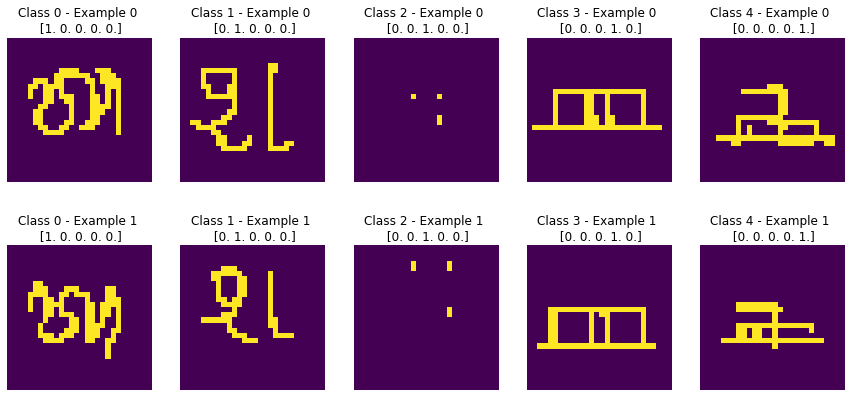

In [5]:
import matplotlib.pyplot as plt

n_way = 5
k_shot = 2
data_path = './omniglot_resized'
meta_batch_size = 25

data_generator = DataGenerator(n_way, k_shot*2, n_way, k_shot*2, config={'data_folder': data_path})

all_image_batches, all_label_batches = data_generator.sample_batch(batch_type='meta_train', batch_size=meta_batch_size, shuffle=False, swap=False)

input_tr, input_ts = all_image_batches[:,:,:k_shot,:], all_image_batches[:,:,k_shot:,:]
label_tr, label_ts = all_label_batches[:,:,:k_shot,:], all_label_batches[:,:,k_shot:,:]

def visualize_sample_data(images, label):
    for b in range(len(images)): # batch size
        print("#"*20)
        print("meta-batch {}: ".format(b))
        print("#"*20)
        label
        count = 0
        fig = plt.figure(figsize=(15, 7))
        for sa in range(k_shot): # k-shot
            for cl in range(n_way): # n-way
                plt.subplot(k_shot, n_way, count + 1)
                plt.title("Class {} - Example {} \n {}".format(cl, sa, label[b, cl, sa]))
                image = images[b, cl, sa].reshape((28,28))
                plt.imshow(image)
                plt.axis('off');
                count += 1
        break # first meta batch sample visualization
        
        plt.show()

print("training data")        
images = input_tr
label = label_tr
visualize_sample_data(images, label)


testing data
####################
meta-batch 0: 
####################


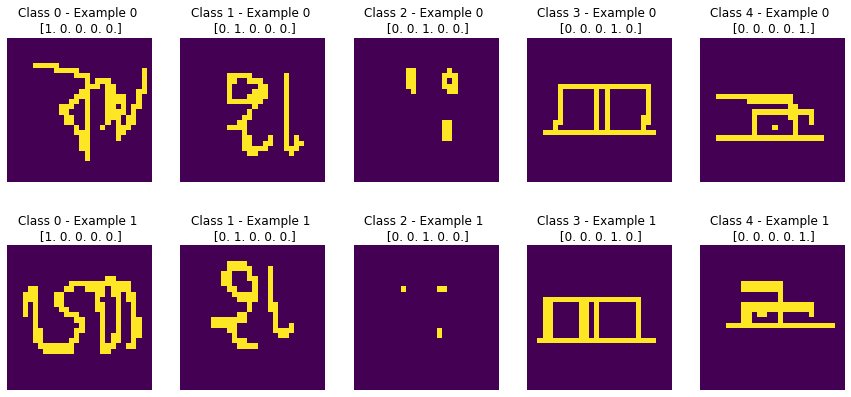

In [6]:
print("testing data")        
images = input_ts
label = label_ts
visualize_sample_data(images, label)

## MAML model

In [7]:
"""MAML model code"""
import numpy as np
import sys
import tensorflow as tf
from functools import partial


class MAML(tf.keras.Model):
    def __init__(self, dim_input=1, dim_output=1, 
                 num_inner_updates=1,
                 inner_update_lr=0.4, num_filters=32, 
                 k_shot=5, learn_inner_update_lr=False):
        super(MAML, self).__init__()
        self.dim_input = dim_input
        self.dim_output = dim_output
        self.inner_update_lr = inner_update_lr
        self.loss_func = partial(cross_entropy_loss, k_shot=k_shot)
        self.dim_hidden = num_filters
        self.channels = 1
        self.img_size = int(np.sqrt(self.dim_input/self.channels))
    
        # outputs_ts[i] and losses_ts_post[i] are the output and loss after i+1 inner gradient updates
        losses_tr_pre, outputs_tr, losses_ts_post, outputs_ts = [], [], [], []
        accuracies_tr_pre, accuracies_ts = [], []
    
        # for each loop in the inner training loop
        outputs_ts = [[]]*num_inner_updates
        losses_ts_post = [[]]*num_inner_updates
        accuracies_ts = [[]]*num_inner_updates
    
        # Define the weights - these should NOT be directly modified by the
        # inner training loop
        tf.random.set_seed(seed)
        self.conv_layers = ConvLayers(self.channels, self.dim_hidden, self.dim_output, self.img_size)
    
        self.learn_inner_update_lr = learn_inner_update_lr
        if self.learn_inner_update_lr:
            self.inner_update_lr_dict = {}
            for key in self.conv_layers.conv_weights.keys():
                self.inner_update_lr_dict[key] = [tf.Variable(self.inner_update_lr, name='inner_update_lr_%s_%d' % (key, j)) for j in range(num_inner_updates)]
  
    #@tf.function
    def call(self, inp, meta_batch_size=25, num_inner_updates=1):
        def task_inner_loop(inp, reuse=True,
                      meta_batch_size=25, num_inner_updates=1):
            """
            Perform gradient descent for one task in the meta-batch (i.e. inner-loop).
                Args:
                    inp: a tuple (input_tr, input_ts, label_tr, label_ts), where input_tr and label_tr are the inputs and
                        labels used for calculating inner loop gradients and input_ts and label_ts are the inputs and
                        labels used for evaluating the model after inner updates.
                        Should be shapes:
                            input_tr: [N*K, 784]
                            input_ts: [N*K, 784]
                            label_tr: [N*K, N]
                            label_ts: [N*K, N]
                Returns:
                    task_output: a list of outputs, losses and accuracies at each inner update
            """
            # the inner and outer loop data
            input_tr, input_ts, label_tr, label_ts = inp
            
            # weights corresponds to the initial weights in MAML (i.e. the meta-parameters)
            weights = self.conv_layers.conv_weights
            
            # the predicted outputs, loss values, and accuracy for the pre-update model (with the initial weights)
            # evaluated on the inner loop training data
            task_output_tr_pre, task_loss_tr_pre, task_accuracy_tr_pre = None, None, None
      
            # lists to keep track of outputs, losses, and accuracies of test data for each inner_update
            # where task_outputs_ts[i], task_losses_ts[i], task_accuracies_ts[i] are the output, loss, and accuracy
            # after i+1 inner gradient updates
            task_outputs_ts, task_losses_ts, task_accuracies_ts = [], [], []
        
            #######################################################################################
            # perform num_inner_updates to get modified weights
            # modified weights should be used to evaluate performance
            # Note that at each inner update, always use input_tr and label_tr for calculating gradients
            # and use input_ts and labels for evaluating performance
      
            # HINTS: You will need to use tf.GradientTape().
            # Read through the tf.GradientTape() documentation to see how 'persistent' should be set.
            # Here is some documentation that may be useful: 
            # https://www.tensorflow.org/guide/advanced_autodiff#higher-order_gradients
            # https://www.tensorflow.org/api_docs/python/tf/GradientTape
            for i in range(num_inner_updates):
                with tf.GradientTape(persistent=True) as inner_tape:
                    # calcuating meta_train loss with training data [input_tr, label_tr]
                    task_output_tr_pre = self.conv_layers(inp=input_tr, weights=weights)
                    task_loss_tr_pre = self.loss_func(task_output_tr_pre, label_tr)
                    # end of with block
                    
                #############################
                ####      Question       #### 
                #### YOUR CODE GOES HERE ####
    
                # 1) calculating gradients for inner task with training data
                gradient=inner_tape.gradient(task_loss_tr_pre,weights)
                
                # 2) learning fast wegiths with inner task gradients (meta parameter "self.conv_layers.conv_weights" shouldn't be updated!)
                fast_weights={w_name:w-self.inner_update_lr*gradient[w_name] for w_name, w in weights.items()}
                # calcuating adaptation loss(task_outputs_ts, task_losses_ts) with testing data [input_ts, label_ts]
                task_outputs_ts.append(self.conv_layers(input_ts, fast_weights)) 
                task_losses_ts.append(self.loss_func(task_outputs_ts[-1], label_ts))
                
                #############################
            
            #######################################################################################
      
            # Compute accuracies from output predictions
            task_accuracy_tr_pre = accuracy(tf.argmax(input=label_tr, axis=1), tf.argmax(input=tf.nn.softmax(task_output_tr_pre), axis=1))
            
            for j in range(num_inner_updates):
                task_accuracies_ts.append(accuracy(tf.argmax(input=label_ts, axis=1), tf.argmax(input=tf.nn.softmax(task_outputs_ts[j]), axis=1)))
            
            # Task Output
            ## task_output_tr_pre    -> tf.float32
            ## task_outputs_ts       -> [tf.float32]*num_inner_updates
            ## task_loss_tr_pre      -> tf.float32
            ## task_losses_ts        -> [tf.float32]*num_inner_updates
            ## task_accuracy_tr_pre  -> tf.float32
            ## task_accuracies_ts    -> [tf.float32]*num_inner_updates
            
            task_output = [task_output_tr_pre, task_outputs_ts, task_loss_tr_pre, task_losses_ts, task_accuracy_tr_pre, task_accuracies_ts]
             
            return task_output

        input_tr, input_ts, label_tr, label_ts = inp
        
        # to initialize the batch norm vars, might want to combine this, and not run idx 0 twice.
        unused = task_inner_loop((input_tr[0], input_ts[0], label_tr[0], label_ts[0]),
                                 False,
                                 meta_batch_size,
                                 num_inner_updates)
        out_dtype = [tf.float32, [tf.float32]*num_inner_updates, tf.float32, [tf.float32]*num_inner_updates]
        out_dtype.extend([tf.float32, [tf.float32]*num_inner_updates])
        
        task_inner_loop_partial = partial(task_inner_loop, meta_batch_size=meta_batch_size, num_inner_updates=num_inner_updates)
        
        result = tf.map_fn(task_inner_loop_partial,
                           elems=(input_tr, input_ts, label_tr, label_ts),
                           dtype=out_dtype,
                           parallel_iterations=meta_batch_size)    
        
        return result

## Model Training

In [8]:
"""Model training code"""
"""
Usage Instructions:
  5-way, 1-shot omniglot:
    python main.py --meta_train_iterations=15000 --meta_batch_size=25 --k_shot=1 --inner_update_lr=0.4 --num_inner_updates=1 --logdir=logs/omniglot5way/
  20-way, 1-shot omniglot:
    python main.py --meta_train_iterations=15000 --meta_batch_size=16 --k_shot=1 --n_way=20 --inner_update_lr=0.1 --num_inner_updates=5 --logdir=logs/omniglot20way/
  To run evaluation, use the '--meta_train=False' flag and the '--meta_test_set=True' flag to use the meta-test set.
"""
import csv
import numpy as np
import pickle
import random
import tensorflow as tf

def outer_train_step(inp, model, optim, meta_batch_size=25, num_inner_updates=1):
    with tf.GradientTape(persistent=False) as outer_tape:
        result = model(inp, meta_batch_size=meta_batch_size, num_inner_updates=num_inner_updates)
    
        outputs_tr, outputs_ts, losses_tr_pre, losses_ts, accuracies_tr_pre, accuracies_ts = result
    
        total_losses_ts = [tf.reduce_mean(loss_ts) for loss_ts in losses_ts]

    gradients = outer_tape.gradient(total_losses_ts[-1], model.trainable_variables)
    optim.apply_gradients(zip(gradients, model.trainable_variables))
  
    total_loss_tr_pre = tf.reduce_mean(losses_tr_pre)
    total_accuracy_tr_pre = tf.reduce_mean(accuracies_tr_pre)
    total_accuracies_ts = [tf.reduce_mean(accuracy_ts) for accuracy_ts in accuracies_ts]

    return outputs_tr, outputs_ts, total_loss_tr_pre, total_losses_ts, total_accuracy_tr_pre, total_accuracies_ts

def outer_eval_step(inp, model, meta_batch_size=25, num_inner_updates=1):
    result = model(inp, meta_batch_size=meta_batch_size, num_inner_updates=num_inner_updates)
  
    outputs_tr, outputs_ts, losses_tr_pre, losses_ts, accuracies_tr_pre, accuracies_ts = result
  
    total_loss_tr_pre = tf.reduce_mean(losses_tr_pre)
    total_losses_ts = [tf.reduce_mean(loss_ts) for loss_ts in losses_ts]
  
    total_accuracy_tr_pre = tf.reduce_mean(accuracies_tr_pre)
    total_accuracies_ts = [tf.reduce_mean(accuracy_ts) for accuracy_ts in accuracies_ts]
  
    return outputs_tr, outputs_ts, total_loss_tr_pre, total_losses_ts, total_accuracy_tr_pre, total_accuracies_ts  


def meta_train_fn(model, exp_string, data_generator,
               n_way=5, meta_train_iterations=15000, meta_batch_size=25,
               log=True, logdir='./log/model', k_shot=1, num_inner_updates=1, meta_lr=0.001):
    SUMMARY_INTERVAL = 10
    SAVE_INTERVAL = 100
    PRINT_INTERVAL = 10  
    TEST_PRINT_INTERVAL = PRINT_INTERVAL*5
  
    pre_accuracies, post_accuracies = [], []
  
    num_classes = data_generator.num_classes
    img_size = data_generator.img_size
  
    optimizer = tf.keras.optimizers.Adam(learning_rate=meta_lr)

    for itr in range(meta_train_iterations):
    
        # sample a batch of training data and partition into
        # the support/training set (input_tr, label_tr) and the query/test set (input_ts, label_ts)
        # NOTE: The code assumes that the support and query sets have the same number of examples.
        
        all_image_batches, all_label_batches = data_generator.sample_batch(batch_type='meta_train', batch_size=meta_batch_size, shuffle=False, swap=False)
        
        input_tr, input_ts = all_image_batches[:,:,:k_shot,:], all_image_batches[:,:,k_shot:,:]
        label_tr, label_ts = all_label_batches[:,:,:k_shot,:], all_label_batches[:,:,k_shot:,:]
        
        # reshape input tensor
        input_tr = tf.reshape(input_tr, [-1, n_way*k_shot, img_size[0]*img_size[0]])
        input_ts = tf.reshape(input_ts, [-1, n_way*k_shot, img_size[0]*img_size[0]])
        label_tr = tf.reshape(label_tr, [-1, n_way*k_shot, n_way])
        label_ts = tf.reshape(label_ts, [-1, n_way*k_shot, n_way])
    
    
        inp = (input_tr, input_ts, label_tr, label_ts)
        
        result = outer_train_step(inp, model, optimizer, meta_batch_size=meta_batch_size, num_inner_updates=num_inner_updates)
    
        if itr % SUMMARY_INTERVAL == 0:
            pre_accuracies.append(result[-2])
            post_accuracies.append(result[-1][-1])
    
        if (itr!=0) and itr % PRINT_INTERVAL == 0:
            print_str = 'Iteration %d: pre-inner-loop train accuracy: %.5f, post-inner-loop test accuracy: %.5f' % (itr, np.mean(pre_accuracies), np.mean(post_accuracies))
            print(print_str)
            pre_accuracies, post_accuracies = [], []
    
        if (itr!=0) and itr % TEST_PRINT_INTERVAL == 0:
      
            # sample a batch of validation data and partition it into
            # the support/training set (input_tr, label_tr) and the query/test set (input_ts, label_ts)
            # NOTE: The code assumes that the support and query sets have the same number of examples.
        
            all_image_batches, all_label_batches = data_generator.sample_batch(batch_type='meta_val', batch_size=meta_batch_size, shuffle=False, swap=False)

            input_tr, input_ts = all_image_batches[:,:,:k_shot,:], all_image_batches[:,:,k_shot:,:]
            label_tr, label_ts = all_label_batches[:,:,:k_shot,:], all_label_batches[:,:,k_shot:,:]
            
            # reshape input tensor
            input_tr = tf.reshape(input_tr, [-1, n_way*k_shot, img_size[0]*img_size[0]])
            input_ts = tf.reshape(input_ts, [-1, n_way*k_shot, img_size[0]*img_size[0]])
            label_tr = tf.reshape(label_tr, [-1, n_way*k_shot, n_way])
            label_ts = tf.reshape(label_ts, [-1, n_way*k_shot, n_way])
    
      
            inp = (input_tr, input_ts, label_tr, label_ts)
            result = outer_eval_step(inp, model, meta_batch_size=meta_batch_size, num_inner_updates=num_inner_updates)
      
            print('Meta-validation pre-inner-loop train accuracy: %.5f, meta-validation post-inner-loop test accuracy: %.5f' % (result[-2], result[-1][-1]))

        
            model_file = logdir + '/' + exp_string +  '/model' + str(itr)
            print("Saving to ", model_file)
            model.save_weights(model_file)
    
    model_file = logdir + '/' + exp_string +  '/model' + str(itr)
    print("Saving to ", model_file)
    model.save_weights(model_file)

# calculated for omniglot
NUM_META_TEST_POINTS = 600

def meta_test_fn(model, data_generator, n_way=5, 
                 meta_batch_size=25, k_shot=1,
                 num_inner_updates=1):
  
    num_classes = data_generator.num_classes
    img_size = data_generator.img_size
  
    np.random.seed(1)
    random.seed(1)
  
    meta_test_accuracies = []
  
    for _ in range(NUM_META_TEST_POINTS):
    
        # sample a batch of test data and partition it into
        # the support/training set (input_tr, label_tr) and the query/test set (input_ts, label_ts)
        # NOTE: The code assumes that the support and query sets have the same number of examples.
        
        all_image_batches, all_label_batches = data_generator.sample_batch(batch_type='meta_test', batch_size=meta_batch_size, shuffle=False, swap=False)
        
        input_tr, input_ts = all_image_batches[:,:,:k_shot,:], all_image_batches[:,:,k_shot:,:]
        label_tr, label_ts = all_label_batches[:,:,:k_shot,:], all_label_batches[:,:,k_shot:,:]
        
        # reshape input tensor
        input_tr = tf.reshape(input_tr, [-1, n_way*k_shot, img_size[0]*img_size[0]])
        input_ts = tf.reshape(input_ts, [-1, n_way*k_shot, img_size[0]*img_size[0]])
        label_tr = tf.reshape(label_tr, [-1, n_way*k_shot, n_way])
        label_ts = tf.reshape(label_ts, [-1, n_way*k_shot, n_way])

        
        inp = (input_tr, input_ts, label_tr, label_ts)
        result = outer_eval_step(inp, model, meta_batch_size=meta_batch_size, num_inner_updates=num_inner_updates)
    
        meta_test_accuracies.append(result[-1][-1])

    meta_test_accuracies = np.array(meta_test_accuracies)
    means = np.mean(meta_test_accuracies)
    stds = np.std(meta_test_accuracies)
    ci95 = 1.96*stds/np.sqrt(NUM_META_TEST_POINTS)
  
    print('Mean meta-test accuracy/loss, stddev, and confidence intervals')
    print((means, stds, ci95))


def run_maml(n_way=5, k_shot=1, meta_batch_size=25, meta_lr=0.001,
             inner_update_lr=0.4, num_filters=32, num_inner_updates=1,
             learn_inner_update_lr=False,
             resume=False, resume_itr=0, log=True, logdir='./log/model',
             data_path='./omniglot_resized',meta_train=True,
             meta_train_iterations=15000, meta_train_k_shot=-1,
             meta_train_inner_update_lr=-1):


    # call data_generator and get data with k_shot*2 samples per class
    data_generator = DataGenerator(n_way, k_shot*2, n_way, k_shot*2, config={'data_folder': data_path})
  
    # set up MAML model
    dim_output = data_generator.dim_output
    dim_input = data_generator.dim_input
    model = MAML(dim_input,
                dim_output,
                num_inner_updates=num_inner_updates,
                inner_update_lr=inner_update_lr,
                k_shot=k_shot,
                num_filters=num_filters,
                learn_inner_update_lr=learn_inner_update_lr)

    if meta_train_k_shot == -1:
        meta_train_k_shot = k_shot
    if meta_train_inner_update_lr == -1:
        meta_train_inner_update_lr = inner_update_lr

    exp_string = 'cls_'+str(n_way)+'.mbs_'+str(meta_batch_size) + '.k_shot_' + str(meta_train_k_shot) + '.inner_numstep_' + str(num_inner_updates) + '.inner_updatelr_' + str(meta_train_inner_update_lr) + '.learn_inner_update_lr_' + str(learn_inner_update_lr)

    if meta_train:
        meta_train_fn(model, exp_string, data_generator,
                      n_way, meta_train_iterations, meta_batch_size, log, logdir,
                      k_shot, num_inner_updates, meta_lr)
    else:
        meta_batch_size = 1
    
        model_file = tf.train.latest_checkpoint(logdir + '/' + exp_string)
        print("Restoring model weights from ", model_file)
        model.load_weights(model_file)
    
        meta_test_fn(model, data_generator, n_way, meta_batch_size, k_shot, num_inner_updates)
  

In [13]:
run_maml(n_way=5, k_shot=1, inner_update_lr=0.4, num_inner_updates=1, meta_train_iterations=5000, logdir='./log/model')

Iteration 10: pre-inner-loop train accuracy: 0.19200, post-inner-loop test accuracy: 0.20800
Iteration 20: pre-inner-loop train accuracy: 0.19200, post-inner-loop test accuracy: 0.20000
Iteration 30: pre-inner-loop train accuracy: 0.19200, post-inner-loop test accuracy: 0.18400
Iteration 40: pre-inner-loop train accuracy: 0.18400, post-inner-loop test accuracy: 0.17600
Iteration 50: pre-inner-loop train accuracy: 0.13600, post-inner-loop test accuracy: 0.21600
Meta-validation pre-inner-loop train accuracy: 0.20800, meta-validation post-inner-loop test accuracy: 0.20800
Saving to  ./log/model/cls_5.mbs_25.k_shot_1.inner_numstep_1.inner_updatelr_0.4.learn_inner_update_lr_False/model50
Iteration 60: pre-inner-loop train accuracy: 0.21600, post-inner-loop test accuracy: 0.20000
Iteration 70: pre-inner-loop train accuracy: 0.25600, post-inner-loop test accuracy: 0.20000
Iteration 80: pre-inner-loop train accuracy: 0.18400, post-inner-loop test accuracy: 0.23200
Iteration 90: pre-inner-loop 

Iteration 600: pre-inner-loop train accuracy: 0.20800, post-inner-loop test accuracy: 0.36000
Meta-validation pre-inner-loop train accuracy: 0.16800, meta-validation post-inner-loop test accuracy: 0.30400
Saving to  ./log/model/cls_5.mbs_25.k_shot_1.inner_numstep_1.inner_updatelr_0.4.learn_inner_update_lr_False/model600
Iteration 610: pre-inner-loop train accuracy: 0.14400, post-inner-loop test accuracy: 0.33600
Iteration 620: pre-inner-loop train accuracy: 0.19200, post-inner-loop test accuracy: 0.37600
Iteration 630: pre-inner-loop train accuracy: 0.20800, post-inner-loop test accuracy: 0.35200
Iteration 640: pre-inner-loop train accuracy: 0.18400, post-inner-loop test accuracy: 0.38400
Iteration 650: pre-inner-loop train accuracy: 0.17600, post-inner-loop test accuracy: 0.35200
Meta-validation pre-inner-loop train accuracy: 0.26400, meta-validation post-inner-loop test accuracy: 0.38400
Saving to  ./log/model/cls_5.mbs_25.k_shot_1.inner_numstep_1.inner_updatelr_0.4.learn_inner_updat

Iteration 1180: pre-inner-loop train accuracy: 0.20000, post-inner-loop test accuracy: 0.40800
Iteration 1190: pre-inner-loop train accuracy: 0.16000, post-inner-loop test accuracy: 0.38400
Iteration 1200: pre-inner-loop train accuracy: 0.20800, post-inner-loop test accuracy: 0.36800
Meta-validation pre-inner-loop train accuracy: 0.16000, meta-validation post-inner-loop test accuracy: 0.40000
Saving to  ./log/model/cls_5.mbs_25.k_shot_1.inner_numstep_1.inner_updatelr_0.4.learn_inner_update_lr_False/model1200
Iteration 1210: pre-inner-loop train accuracy: 0.20000, post-inner-loop test accuracy: 0.43200
Iteration 1220: pre-inner-loop train accuracy: 0.28800, post-inner-loop test accuracy: 0.39200
Iteration 1230: pre-inner-loop train accuracy: 0.18400, post-inner-loop test accuracy: 0.40800
Iteration 1240: pre-inner-loop train accuracy: 0.28000, post-inner-loop test accuracy: 0.44000
Iteration 1250: pre-inner-loop train accuracy: 0.17600, post-inner-loop test accuracy: 0.44000
Meta-valida

Iteration 1760: pre-inner-loop train accuracy: 0.23200, post-inner-loop test accuracy: 0.44800
Iteration 1770: pre-inner-loop train accuracy: 0.17600, post-inner-loop test accuracy: 0.56800
Iteration 1780: pre-inner-loop train accuracy: 0.18400, post-inner-loop test accuracy: 0.56000
Iteration 1790: pre-inner-loop train accuracy: 0.22400, post-inner-loop test accuracy: 0.52000
Iteration 1800: pre-inner-loop train accuracy: 0.18400, post-inner-loop test accuracy: 0.52800
Meta-validation pre-inner-loop train accuracy: 0.13600, meta-validation post-inner-loop test accuracy: 0.57600
Saving to  ./log/model/cls_5.mbs_25.k_shot_1.inner_numstep_1.inner_updatelr_0.4.learn_inner_update_lr_False/model1800
Iteration 1810: pre-inner-loop train accuracy: 0.21600, post-inner-loop test accuracy: 0.51200
Iteration 1820: pre-inner-loop train accuracy: 0.16800, post-inner-loop test accuracy: 0.49600
Iteration 1830: pre-inner-loop train accuracy: 0.16800, post-inner-loop test accuracy: 0.56000
Iteration 1

Meta-validation pre-inner-loop train accuracy: 0.18400, meta-validation post-inner-loop test accuracy: 0.58400
Saving to  ./log/model/cls_5.mbs_25.k_shot_1.inner_numstep_1.inner_updatelr_0.4.learn_inner_update_lr_False/model2350
Iteration 2360: pre-inner-loop train accuracy: 0.18400, post-inner-loop test accuracy: 0.60800
Iteration 2370: pre-inner-loop train accuracy: 0.20800, post-inner-loop test accuracy: 0.57600
Iteration 2380: pre-inner-loop train accuracy: 0.24000, post-inner-loop test accuracy: 0.53600
Iteration 2390: pre-inner-loop train accuracy: 0.20800, post-inner-loop test accuracy: 0.47200
Iteration 2400: pre-inner-loop train accuracy: 0.21600, post-inner-loop test accuracy: 0.52000
Meta-validation pre-inner-loop train accuracy: 0.20000, meta-validation post-inner-loop test accuracy: 0.52000
Saving to  ./log/model/cls_5.mbs_25.k_shot_1.inner_numstep_1.inner_updatelr_0.4.learn_inner_update_lr_False/model2400
Iteration 2410: pre-inner-loop train accuracy: 0.15200, post-inner-

Iteration 2940: pre-inner-loop train accuracy: 0.17600, post-inner-loop test accuracy: 0.55200
Iteration 2950: pre-inner-loop train accuracy: 0.18400, post-inner-loop test accuracy: 0.61600
Meta-validation pre-inner-loop train accuracy: 0.24800, meta-validation post-inner-loop test accuracy: 0.63200
Saving to  ./log/model/cls_5.mbs_25.k_shot_1.inner_numstep_1.inner_updatelr_0.4.learn_inner_update_lr_False/model2950
Iteration 2960: pre-inner-loop train accuracy: 0.24800, post-inner-loop test accuracy: 0.55200
Iteration 2970: pre-inner-loop train accuracy: 0.20800, post-inner-loop test accuracy: 0.60800
Iteration 2980: pre-inner-loop train accuracy: 0.25600, post-inner-loop test accuracy: 0.60000
Iteration 2990: pre-inner-loop train accuracy: 0.17600, post-inner-loop test accuracy: 0.55200
Iteration 3000: pre-inner-loop train accuracy: 0.16800, post-inner-loop test accuracy: 0.57600
Meta-validation pre-inner-loop train accuracy: 0.24800, meta-validation post-inner-loop test accuracy: 0.5

Iteration 3520: pre-inner-loop train accuracy: 0.20800, post-inner-loop test accuracy: 0.59200
Iteration 3530: pre-inner-loop train accuracy: 0.20000, post-inner-loop test accuracy: 0.58400
Iteration 3540: pre-inner-loop train accuracy: 0.21600, post-inner-loop test accuracy: 0.62400
Iteration 3550: pre-inner-loop train accuracy: 0.20000, post-inner-loop test accuracy: 0.58400
Meta-validation pre-inner-loop train accuracy: 0.27200, meta-validation post-inner-loop test accuracy: 0.59200
Saving to  ./log/model/cls_5.mbs_25.k_shot_1.inner_numstep_1.inner_updatelr_0.4.learn_inner_update_lr_False/model3550
Iteration 3560: pre-inner-loop train accuracy: 0.13600, post-inner-loop test accuracy: 0.60800
Iteration 3570: pre-inner-loop train accuracy: 0.24000, post-inner-loop test accuracy: 0.62400
Iteration 3580: pre-inner-loop train accuracy: 0.22400, post-inner-loop test accuracy: 0.56800
Iteration 3590: pre-inner-loop train accuracy: 0.15200, post-inner-loop test accuracy: 0.64800
Iteration 3

Iteration 4110: pre-inner-loop train accuracy: 0.20000, post-inner-loop test accuracy: 0.59200
Iteration 4120: pre-inner-loop train accuracy: 0.25600, post-inner-loop test accuracy: 0.66400
Iteration 4130: pre-inner-loop train accuracy: 0.24800, post-inner-loop test accuracy: 0.60000
Iteration 4140: pre-inner-loop train accuracy: 0.21600, post-inner-loop test accuracy: 0.57600
Iteration 4150: pre-inner-loop train accuracy: 0.20000, post-inner-loop test accuracy: 0.56800
Meta-validation pre-inner-loop train accuracy: 0.18400, meta-validation post-inner-loop test accuracy: 0.59200
Saving to  ./log/model/cls_5.mbs_25.k_shot_1.inner_numstep_1.inner_updatelr_0.4.learn_inner_update_lr_False/model4150
Iteration 4160: pre-inner-loop train accuracy: 0.17600, post-inner-loop test accuracy: 0.55200
Iteration 4170: pre-inner-loop train accuracy: 0.20800, post-inner-loop test accuracy: 0.58400
Iteration 4180: pre-inner-loop train accuracy: 0.24800, post-inner-loop test accuracy: 0.57600
Iteration 4

Meta-validation pre-inner-loop train accuracy: 0.20000, meta-validation post-inner-loop test accuracy: 0.56800
Saving to  ./log/model/cls_5.mbs_25.k_shot_1.inner_numstep_1.inner_updatelr_0.4.learn_inner_update_lr_False/model4700
Iteration 4710: pre-inner-loop train accuracy: 0.24800, post-inner-loop test accuracy: 0.64800
Iteration 4720: pre-inner-loop train accuracy: 0.23200, post-inner-loop test accuracy: 0.65600
Iteration 4730: pre-inner-loop train accuracy: 0.29600, post-inner-loop test accuracy: 0.63200
Iteration 4740: pre-inner-loop train accuracy: 0.12800, post-inner-loop test accuracy: 0.60000
Iteration 4750: pre-inner-loop train accuracy: 0.24000, post-inner-loop test accuracy: 0.61600
Meta-validation pre-inner-loop train accuracy: 0.23200, meta-validation post-inner-loop test accuracy: 0.56000
Saving to  ./log/model/cls_5.mbs_25.k_shot_1.inner_numstep_1.inner_updatelr_0.4.learn_inner_update_lr_False/model4750
Iteration 4760: pre-inner-loop train accuracy: 0.16000, post-inner-

In [9]:
run_maml(n_way=5, k_shot=1, inner_update_lr=0.4, num_inner_updates=1, meta_train=False, logdir='./log/model/')

Restoring model weights from  ./log/model//cls_5.mbs_25.k_shot_1.inner_numstep_1.inner_updatelr_0.4.learn_inner_update_lr_False\model4999
Mean meta-test accuracy/loss, stddev, and confidence intervals
(0.62766665, 0.19140156, 0.015315314184448326)


In [23]:
run_maml(n_way=5, k_shot=1, inner_update_lr=0.6, num_inner_updates=1, meta_train_iterations=5000, logdir='./log/model')

Iteration 10: pre-inner-loop train accuracy: 0.20000, post-inner-loop test accuracy: 0.19200
Iteration 20: pre-inner-loop train accuracy: 0.18400, post-inner-loop test accuracy: 0.20000
Iteration 30: pre-inner-loop train accuracy: 0.20000, post-inner-loop test accuracy: 0.19200
Iteration 40: pre-inner-loop train accuracy: 0.20800, post-inner-loop test accuracy: 0.19200
Iteration 50: pre-inner-loop train accuracy: 0.21600, post-inner-loop test accuracy: 0.20800
Meta-validation pre-inner-loop train accuracy: 0.19200, meta-validation post-inner-loop test accuracy: 0.21600
Saving to  ./log/model/cls_5.mbs_25.k_shot_1.inner_numstep_1.inner_updatelr_0.6.learn_inner_update_lr_False/model50
Iteration 60: pre-inner-loop train accuracy: 0.20000, post-inner-loop test accuracy: 0.20000
Iteration 70: pre-inner-loop train accuracy: 0.20800, post-inner-loop test accuracy: 0.22400
Iteration 80: pre-inner-loop train accuracy: 0.17600, post-inner-loop test accuracy: 0.23200
Iteration 90: pre-inner-loop 

Iteration 610: pre-inner-loop train accuracy: 0.20000, post-inner-loop test accuracy: 0.39200
Iteration 620: pre-inner-loop train accuracy: 0.20000, post-inner-loop test accuracy: 0.37600
Iteration 630: pre-inner-loop train accuracy: 0.25600, post-inner-loop test accuracy: 0.38400
Iteration 640: pre-inner-loop train accuracy: 0.16800, post-inner-loop test accuracy: 0.40000
Iteration 650: pre-inner-loop train accuracy: 0.21600, post-inner-loop test accuracy: 0.36800
Meta-validation pre-inner-loop train accuracy: 0.12000, meta-validation post-inner-loop test accuracy: 0.37600
Saving to  ./log/model/cls_5.mbs_25.k_shot_1.inner_numstep_1.inner_updatelr_0.6.learn_inner_update_lr_False/model650
Iteration 660: pre-inner-loop train accuracy: 0.21600, post-inner-loop test accuracy: 0.40800
Iteration 670: pre-inner-loop train accuracy: 0.21600, post-inner-loop test accuracy: 0.44800
Iteration 680: pre-inner-loop train accuracy: 0.16000, post-inner-loop test accuracy: 0.36800
Iteration 690: pre-i

Iteration 1210: pre-inner-loop train accuracy: 0.16800, post-inner-loop test accuracy: 0.43200
Iteration 1220: pre-inner-loop train accuracy: 0.18400, post-inner-loop test accuracy: 0.45600
Iteration 1230: pre-inner-loop train accuracy: 0.19200, post-inner-loop test accuracy: 0.51200
Iteration 1240: pre-inner-loop train accuracy: 0.25600, post-inner-loop test accuracy: 0.54400
Iteration 1250: pre-inner-loop train accuracy: 0.21600, post-inner-loop test accuracy: 0.50400
Meta-validation pre-inner-loop train accuracy: 0.20800, meta-validation post-inner-loop test accuracy: 0.48800
Saving to  ./log/model/cls_5.mbs_25.k_shot_1.inner_numstep_1.inner_updatelr_0.6.learn_inner_update_lr_False/model1250
Iteration 1260: pre-inner-loop train accuracy: 0.15200, post-inner-loop test accuracy: 0.54400
Iteration 1270: pre-inner-loop train accuracy: 0.12000, post-inner-loop test accuracy: 0.45600
Iteration 1280: pre-inner-loop train accuracy: 0.17600, post-inner-loop test accuracy: 0.52000
Iteration 1

Meta-validation pre-inner-loop train accuracy: 0.19200, meta-validation post-inner-loop test accuracy: 0.57600
Saving to  ./log/model/cls_5.mbs_25.k_shot_1.inner_numstep_1.inner_updatelr_0.6.learn_inner_update_lr_False/model1800
Iteration 1810: pre-inner-loop train accuracy: 0.20000, post-inner-loop test accuracy: 0.51200
Iteration 1820: pre-inner-loop train accuracy: 0.21600, post-inner-loop test accuracy: 0.48000
Iteration 1830: pre-inner-loop train accuracy: 0.14400, post-inner-loop test accuracy: 0.56800
Iteration 1840: pre-inner-loop train accuracy: 0.19200, post-inner-loop test accuracy: 0.54400
Iteration 1850: pre-inner-loop train accuracy: 0.22400, post-inner-loop test accuracy: 0.52800
Meta-validation pre-inner-loop train accuracy: 0.20800, meta-validation post-inner-loop test accuracy: 0.54400
Saving to  ./log/model/cls_5.mbs_25.k_shot_1.inner_numstep_1.inner_updatelr_0.6.learn_inner_update_lr_False/model1850
Iteration 1860: pre-inner-loop train accuracy: 0.17600, post-inner-

Iteration 2390: pre-inner-loop train accuracy: 0.24800, post-inner-loop test accuracy: 0.53600
Iteration 2400: pre-inner-loop train accuracy: 0.16000, post-inner-loop test accuracy: 0.53600
Meta-validation pre-inner-loop train accuracy: 0.24000, meta-validation post-inner-loop test accuracy: 0.56000
Saving to  ./log/model/cls_5.mbs_25.k_shot_1.inner_numstep_1.inner_updatelr_0.6.learn_inner_update_lr_False/model2400
Iteration 2410: pre-inner-loop train accuracy: 0.19200, post-inner-loop test accuracy: 0.48800
Iteration 2420: pre-inner-loop train accuracy: 0.23200, post-inner-loop test accuracy: 0.56800
Iteration 2430: pre-inner-loop train accuracy: 0.24800, post-inner-loop test accuracy: 0.57600
Iteration 2440: pre-inner-loop train accuracy: 0.16800, post-inner-loop test accuracy: 0.61600
Iteration 2450: pre-inner-loop train accuracy: 0.24000, post-inner-loop test accuracy: 0.62400
Meta-validation pre-inner-loop train accuracy: 0.16800, meta-validation post-inner-loop test accuracy: 0.5

Iteration 2970: pre-inner-loop train accuracy: 0.20800, post-inner-loop test accuracy: 0.59200
Iteration 2980: pre-inner-loop train accuracy: 0.20800, post-inner-loop test accuracy: 0.53600
Iteration 2990: pre-inner-loop train accuracy: 0.13600, post-inner-loop test accuracy: 0.57600
Iteration 3000: pre-inner-loop train accuracy: 0.23200, post-inner-loop test accuracy: 0.61600
Meta-validation pre-inner-loop train accuracy: 0.23200, meta-validation post-inner-loop test accuracy: 0.57600
Saving to  ./log/model/cls_5.mbs_25.k_shot_1.inner_numstep_1.inner_updatelr_0.6.learn_inner_update_lr_False/model3000
Iteration 3010: pre-inner-loop train accuracy: 0.21600, post-inner-loop test accuracy: 0.60000
Iteration 3020: pre-inner-loop train accuracy: 0.18400, post-inner-loop test accuracy: 0.53600
Iteration 3030: pre-inner-loop train accuracy: 0.20800, post-inner-loop test accuracy: 0.56800
Iteration 3040: pre-inner-loop train accuracy: 0.19200, post-inner-loop test accuracy: 0.56800
Iteration 3

Iteration 3560: pre-inner-loop train accuracy: 0.20000, post-inner-loop test accuracy: 0.64800
Iteration 3570: pre-inner-loop train accuracy: 0.20000, post-inner-loop test accuracy: 0.64000
Iteration 3580: pre-inner-loop train accuracy: 0.16000, post-inner-loop test accuracy: 0.56800
Iteration 3590: pre-inner-loop train accuracy: 0.24000, post-inner-loop test accuracy: 0.71200
Iteration 3600: pre-inner-loop train accuracy: 0.24000, post-inner-loop test accuracy: 0.64800
Meta-validation pre-inner-loop train accuracy: 0.20800, meta-validation post-inner-loop test accuracy: 0.60800
Saving to  ./log/model/cls_5.mbs_25.k_shot_1.inner_numstep_1.inner_updatelr_0.6.learn_inner_update_lr_False/model3600
Iteration 3610: pre-inner-loop train accuracy: 0.19200, post-inner-loop test accuracy: 0.62400
Iteration 3620: pre-inner-loop train accuracy: 0.24000, post-inner-loop test accuracy: 0.64000
Iteration 3630: pre-inner-loop train accuracy: 0.17600, post-inner-loop test accuracy: 0.59200
Iteration 3

Meta-validation pre-inner-loop train accuracy: 0.16800, meta-validation post-inner-loop test accuracy: 0.59200
Saving to  ./log/model/cls_5.mbs_25.k_shot_1.inner_numstep_1.inner_updatelr_0.6.learn_inner_update_lr_False/model4150
Iteration 4160: pre-inner-loop train accuracy: 0.24800, post-inner-loop test accuracy: 0.56800
Iteration 4170: pre-inner-loop train accuracy: 0.20000, post-inner-loop test accuracy: 0.64800
Iteration 4180: pre-inner-loop train accuracy: 0.17600, post-inner-loop test accuracy: 0.54400
Iteration 4190: pre-inner-loop train accuracy: 0.20000, post-inner-loop test accuracy: 0.55200
Iteration 4200: pre-inner-loop train accuracy: 0.26400, post-inner-loop test accuracy: 0.64000
Meta-validation pre-inner-loop train accuracy: 0.16800, meta-validation post-inner-loop test accuracy: 0.64800
Saving to  ./log/model/cls_5.mbs_25.k_shot_1.inner_numstep_1.inner_updatelr_0.6.learn_inner_update_lr_False/model4200
Iteration 4210: pre-inner-loop train accuracy: 0.18400, post-inner-

Iteration 4740: pre-inner-loop train accuracy: 0.15200, post-inner-loop test accuracy: 0.55200
Iteration 4750: pre-inner-loop train accuracy: 0.19200, post-inner-loop test accuracy: 0.60800
Meta-validation pre-inner-loop train accuracy: 0.23200, meta-validation post-inner-loop test accuracy: 0.52000
Saving to  ./log/model/cls_5.mbs_25.k_shot_1.inner_numstep_1.inner_updatelr_0.6.learn_inner_update_lr_False/model4750
Iteration 4760: pre-inner-loop train accuracy: 0.13600, post-inner-loop test accuracy: 0.66400
Iteration 4770: pre-inner-loop train accuracy: 0.23200, post-inner-loop test accuracy: 0.67200
Iteration 4780: pre-inner-loop train accuracy: 0.19200, post-inner-loop test accuracy: 0.61600
Iteration 4790: pre-inner-loop train accuracy: 0.22400, post-inner-loop test accuracy: 0.61600
Iteration 4800: pre-inner-loop train accuracy: 0.19200, post-inner-loop test accuracy: 0.56000
Meta-validation pre-inner-loop train accuracy: 0.13600, meta-validation post-inner-loop test accuracy: 0.6

In [24]:
run_maml(n_way=5, k_shot=1, inner_update_lr=0.2, num_inner_updates=1, meta_train_iterations=5000, logdir='./log/model')

Iteration 10: pre-inner-loop train accuracy: 0.19600, post-inner-loop test accuracy: 0.18400
Iteration 20: pre-inner-loop train accuracy: 0.21600, post-inner-loop test accuracy: 0.20800
Iteration 30: pre-inner-loop train accuracy: 0.20000, post-inner-loop test accuracy: 0.19200
Iteration 40: pre-inner-loop train accuracy: 0.18400, post-inner-loop test accuracy: 0.18400
Iteration 50: pre-inner-loop train accuracy: 0.20000, post-inner-loop test accuracy: 0.20800
Meta-validation pre-inner-loop train accuracy: 0.19200, meta-validation post-inner-loop test accuracy: 0.20000
Saving to  ./log/model/cls_5.mbs_25.k_shot_1.inner_numstep_1.inner_updatelr_0.2.learn_inner_update_lr_False/model50
Iteration 60: pre-inner-loop train accuracy: 0.20000, post-inner-loop test accuracy: 0.20800
Iteration 70: pre-inner-loop train accuracy: 0.20000, post-inner-loop test accuracy: 0.21600
Iteration 80: pre-inner-loop train accuracy: 0.24000, post-inner-loop test accuracy: 0.21600
Iteration 90: pre-inner-loop 

Iteration 610: pre-inner-loop train accuracy: 0.18400, post-inner-loop test accuracy: 0.39200
Iteration 620: pre-inner-loop train accuracy: 0.25600, post-inner-loop test accuracy: 0.38400
Iteration 630: pre-inner-loop train accuracy: 0.15200, post-inner-loop test accuracy: 0.37600
Iteration 640: pre-inner-loop train accuracy: 0.22400, post-inner-loop test accuracy: 0.34400
Iteration 650: pre-inner-loop train accuracy: 0.18400, post-inner-loop test accuracy: 0.30400
Meta-validation pre-inner-loop train accuracy: 0.13600, meta-validation post-inner-loop test accuracy: 0.43200
Saving to  ./log/model/cls_5.mbs_25.k_shot_1.inner_numstep_1.inner_updatelr_0.2.learn_inner_update_lr_False/model650
Iteration 660: pre-inner-loop train accuracy: 0.25600, post-inner-loop test accuracy: 0.32800
Iteration 670: pre-inner-loop train accuracy: 0.20000, post-inner-loop test accuracy: 0.38400
Iteration 680: pre-inner-loop train accuracy: 0.25600, post-inner-loop test accuracy: 0.36000
Iteration 690: pre-i

Iteration 1210: pre-inner-loop train accuracy: 0.19200, post-inner-loop test accuracy: 0.44000
Iteration 1220: pre-inner-loop train accuracy: 0.16000, post-inner-loop test accuracy: 0.42400
Iteration 1230: pre-inner-loop train accuracy: 0.24800, post-inner-loop test accuracy: 0.50400
Iteration 1240: pre-inner-loop train accuracy: 0.20000, post-inner-loop test accuracy: 0.49600
Iteration 1250: pre-inner-loop train accuracy: 0.16000, post-inner-loop test accuracy: 0.45600
Meta-validation pre-inner-loop train accuracy: 0.19200, meta-validation post-inner-loop test accuracy: 0.44800
Saving to  ./log/model/cls_5.mbs_25.k_shot_1.inner_numstep_1.inner_updatelr_0.2.learn_inner_update_lr_False/model1250
Iteration 1260: pre-inner-loop train accuracy: 0.18400, post-inner-loop test accuracy: 0.41600
Iteration 1270: pre-inner-loop train accuracy: 0.23200, post-inner-loop test accuracy: 0.47200
Iteration 1280: pre-inner-loop train accuracy: 0.18400, post-inner-loop test accuracy: 0.44000
Iteration 1

Meta-validation pre-inner-loop train accuracy: 0.21600, meta-validation post-inner-loop test accuracy: 0.51200
Saving to  ./log/model/cls_5.mbs_25.k_shot_1.inner_numstep_1.inner_updatelr_0.2.learn_inner_update_lr_False/model1800
Iteration 1810: pre-inner-loop train accuracy: 0.18400, post-inner-loop test accuracy: 0.47200
Iteration 1820: pre-inner-loop train accuracy: 0.24000, post-inner-loop test accuracy: 0.46400
Iteration 1830: pre-inner-loop train accuracy: 0.22400, post-inner-loop test accuracy: 0.49600
Iteration 1840: pre-inner-loop train accuracy: 0.20000, post-inner-loop test accuracy: 0.52000
Iteration 1850: pre-inner-loop train accuracy: 0.19200, post-inner-loop test accuracy: 0.51200
Meta-validation pre-inner-loop train accuracy: 0.19200, meta-validation post-inner-loop test accuracy: 0.50400
Saving to  ./log/model/cls_5.mbs_25.k_shot_1.inner_numstep_1.inner_updatelr_0.2.learn_inner_update_lr_False/model1850
Iteration 1860: pre-inner-loop train accuracy: 0.21600, post-inner-

Iteration 2390: pre-inner-loop train accuracy: 0.20000, post-inner-loop test accuracy: 0.54400
Iteration 2400: pre-inner-loop train accuracy: 0.20000, post-inner-loop test accuracy: 0.52800
Meta-validation pre-inner-loop train accuracy: 0.19200, meta-validation post-inner-loop test accuracy: 0.52800
Saving to  ./log/model/cls_5.mbs_25.k_shot_1.inner_numstep_1.inner_updatelr_0.2.learn_inner_update_lr_False/model2400
Iteration 2410: pre-inner-loop train accuracy: 0.20000, post-inner-loop test accuracy: 0.50400
Iteration 2420: pre-inner-loop train accuracy: 0.14400, post-inner-loop test accuracy: 0.50400
Iteration 2430: pre-inner-loop train accuracy: 0.21600, post-inner-loop test accuracy: 0.57600
Iteration 2440: pre-inner-loop train accuracy: 0.16000, post-inner-loop test accuracy: 0.58400
Iteration 2450: pre-inner-loop train accuracy: 0.20800, post-inner-loop test accuracy: 0.55200
Meta-validation pre-inner-loop train accuracy: 0.17600, meta-validation post-inner-loop test accuracy: 0.5

Iteration 2970: pre-inner-loop train accuracy: 0.17600, post-inner-loop test accuracy: 0.58400
Iteration 2980: pre-inner-loop train accuracy: 0.14400, post-inner-loop test accuracy: 0.57600
Iteration 2990: pre-inner-loop train accuracy: 0.16000, post-inner-loop test accuracy: 0.53600
Iteration 3000: pre-inner-loop train accuracy: 0.24000, post-inner-loop test accuracy: 0.59200
Meta-validation pre-inner-loop train accuracy: 0.17600, meta-validation post-inner-loop test accuracy: 0.58400
Saving to  ./log/model/cls_5.mbs_25.k_shot_1.inner_numstep_1.inner_updatelr_0.2.learn_inner_update_lr_False/model3000
Iteration 3010: pre-inner-loop train accuracy: 0.13600, post-inner-loop test accuracy: 0.57600
Iteration 3020: pre-inner-loop train accuracy: 0.16800, post-inner-loop test accuracy: 0.50400
Iteration 3030: pre-inner-loop train accuracy: 0.20000, post-inner-loop test accuracy: 0.56800
Iteration 3040: pre-inner-loop train accuracy: 0.17600, post-inner-loop test accuracy: 0.56000
Iteration 3

Iteration 3560: pre-inner-loop train accuracy: 0.17600, post-inner-loop test accuracy: 0.68000
Iteration 3570: pre-inner-loop train accuracy: 0.20800, post-inner-loop test accuracy: 0.60800
Iteration 3580: pre-inner-loop train accuracy: 0.23200, post-inner-loop test accuracy: 0.60000
Iteration 3590: pre-inner-loop train accuracy: 0.16000, post-inner-loop test accuracy: 0.66400
Iteration 3600: pre-inner-loop train accuracy: 0.19200, post-inner-loop test accuracy: 0.58400
Meta-validation pre-inner-loop train accuracy: 0.18400, meta-validation post-inner-loop test accuracy: 0.55200
Saving to  ./log/model/cls_5.mbs_25.k_shot_1.inner_numstep_1.inner_updatelr_0.2.learn_inner_update_lr_False/model3600
Iteration 3610: pre-inner-loop train accuracy: 0.20000, post-inner-loop test accuracy: 0.59200
Iteration 3620: pre-inner-loop train accuracy: 0.24000, post-inner-loop test accuracy: 0.55200
Iteration 3630: pre-inner-loop train accuracy: 0.21600, post-inner-loop test accuracy: 0.62400
Iteration 3

Meta-validation pre-inner-loop train accuracy: 0.24000, meta-validation post-inner-loop test accuracy: 0.54400
Saving to  ./log/model/cls_5.mbs_25.k_shot_1.inner_numstep_1.inner_updatelr_0.2.learn_inner_update_lr_False/model4150
Iteration 4160: pre-inner-loop train accuracy: 0.20000, post-inner-loop test accuracy: 0.60800
Iteration 4170: pre-inner-loop train accuracy: 0.19200, post-inner-loop test accuracy: 0.62400
Iteration 4180: pre-inner-loop train accuracy: 0.23200, post-inner-loop test accuracy: 0.61600
Iteration 4190: pre-inner-loop train accuracy: 0.22400, post-inner-loop test accuracy: 0.53600
Iteration 4200: pre-inner-loop train accuracy: 0.20800, post-inner-loop test accuracy: 0.60000
Meta-validation pre-inner-loop train accuracy: 0.20000, meta-validation post-inner-loop test accuracy: 0.66400
Saving to  ./log/model/cls_5.mbs_25.k_shot_1.inner_numstep_1.inner_updatelr_0.2.learn_inner_update_lr_False/model4200
Iteration 4210: pre-inner-loop train accuracy: 0.19200, post-inner-

Iteration 4740: pre-inner-loop train accuracy: 0.21600, post-inner-loop test accuracy: 0.60000
Iteration 4750: pre-inner-loop train accuracy: 0.20800, post-inner-loop test accuracy: 0.65600
Meta-validation pre-inner-loop train accuracy: 0.13600, meta-validation post-inner-loop test accuracy: 0.60800
Saving to  ./log/model/cls_5.mbs_25.k_shot_1.inner_numstep_1.inner_updatelr_0.2.learn_inner_update_lr_False/model4750
Iteration 4760: pre-inner-loop train accuracy: 0.15200, post-inner-loop test accuracy: 0.60800
Iteration 4770: pre-inner-loop train accuracy: 0.16800, post-inner-loop test accuracy: 0.68800
Iteration 4780: pre-inner-loop train accuracy: 0.28800, post-inner-loop test accuracy: 0.66400
Iteration 4790: pre-inner-loop train accuracy: 0.19200, post-inner-loop test accuracy: 0.68800
Iteration 4800: pre-inner-loop train accuracy: 0.13600, post-inner-loop test accuracy: 0.52800
Meta-validation pre-inner-loop train accuracy: 0.14400, meta-validation post-inner-loop test accuracy: 0.6

In [10]:
run_maml(n_way=5, k_shot=1, inner_update_lr=0.4, num_inner_updates=3, meta_train_iterations=5000, logdir='./log/model')

Iteration 10: pre-inner-loop train accuracy: 0.19200, post-inner-loop test accuracy: 0.20800
Iteration 20: pre-inner-loop train accuracy: 0.19200, post-inner-loop test accuracy: 0.20000
Iteration 30: pre-inner-loop train accuracy: 0.19200, post-inner-loop test accuracy: 0.18400
Iteration 40: pre-inner-loop train accuracy: 0.18400, post-inner-loop test accuracy: 0.17600
Iteration 50: pre-inner-loop train accuracy: 0.13600, post-inner-loop test accuracy: 0.21600
Meta-validation pre-inner-loop train accuracy: 0.20800, meta-validation post-inner-loop test accuracy: 0.20800
Saving to  ./log/model/cls_5.mbs_25.k_shot_1.inner_numstep_3.inner_updatelr_0.4.learn_inner_update_lr_False/model50
Iteration 60: pre-inner-loop train accuracy: 0.21600, post-inner-loop test accuracy: 0.20000
Iteration 70: pre-inner-loop train accuracy: 0.25600, post-inner-loop test accuracy: 0.20000
Iteration 80: pre-inner-loop train accuracy: 0.18400, post-inner-loop test accuracy: 0.23200
Iteration 90: pre-inner-loop 

Iteration 600: pre-inner-loop train accuracy: 0.20800, post-inner-loop test accuracy: 0.36000
Meta-validation pre-inner-loop train accuracy: 0.16800, meta-validation post-inner-loop test accuracy: 0.30400
Saving to  ./log/model/cls_5.mbs_25.k_shot_1.inner_numstep_3.inner_updatelr_0.4.learn_inner_update_lr_False/model600
Iteration 610: pre-inner-loop train accuracy: 0.14400, post-inner-loop test accuracy: 0.33600
Iteration 620: pre-inner-loop train accuracy: 0.19200, post-inner-loop test accuracy: 0.37600
Iteration 630: pre-inner-loop train accuracy: 0.20800, post-inner-loop test accuracy: 0.35200
Iteration 640: pre-inner-loop train accuracy: 0.18400, post-inner-loop test accuracy: 0.38400
Iteration 650: pre-inner-loop train accuracy: 0.17600, post-inner-loop test accuracy: 0.35200
Meta-validation pre-inner-loop train accuracy: 0.26400, meta-validation post-inner-loop test accuracy: 0.38400
Saving to  ./log/model/cls_5.mbs_25.k_shot_1.inner_numstep_3.inner_updatelr_0.4.learn_inner_updat

Iteration 1180: pre-inner-loop train accuracy: 0.20000, post-inner-loop test accuracy: 0.40800
Iteration 1190: pre-inner-loop train accuracy: 0.16000, post-inner-loop test accuracy: 0.38400
Iteration 1200: pre-inner-loop train accuracy: 0.20800, post-inner-loop test accuracy: 0.36800
Meta-validation pre-inner-loop train accuracy: 0.16000, meta-validation post-inner-loop test accuracy: 0.40000
Saving to  ./log/model/cls_5.mbs_25.k_shot_1.inner_numstep_3.inner_updatelr_0.4.learn_inner_update_lr_False/model1200
Iteration 1210: pre-inner-loop train accuracy: 0.20000, post-inner-loop test accuracy: 0.43200
Iteration 1220: pre-inner-loop train accuracy: 0.28800, post-inner-loop test accuracy: 0.39200
Iteration 1230: pre-inner-loop train accuracy: 0.18400, post-inner-loop test accuracy: 0.40800
Iteration 1240: pre-inner-loop train accuracy: 0.28000, post-inner-loop test accuracy: 0.44000
Iteration 1250: pre-inner-loop train accuracy: 0.17600, post-inner-loop test accuracy: 0.44000
Meta-valida

Iteration 1760: pre-inner-loop train accuracy: 0.23200, post-inner-loop test accuracy: 0.44800
Iteration 1770: pre-inner-loop train accuracy: 0.17600, post-inner-loop test accuracy: 0.56800
Iteration 1780: pre-inner-loop train accuracy: 0.18400, post-inner-loop test accuracy: 0.56000
Iteration 1790: pre-inner-loop train accuracy: 0.22400, post-inner-loop test accuracy: 0.52000
Iteration 1800: pre-inner-loop train accuracy: 0.18400, post-inner-loop test accuracy: 0.52800
Meta-validation pre-inner-loop train accuracy: 0.13600, meta-validation post-inner-loop test accuracy: 0.57600
Saving to  ./log/model/cls_5.mbs_25.k_shot_1.inner_numstep_3.inner_updatelr_0.4.learn_inner_update_lr_False/model1800
Iteration 1810: pre-inner-loop train accuracy: 0.21600, post-inner-loop test accuracy: 0.51200
Iteration 1820: pre-inner-loop train accuracy: 0.16800, post-inner-loop test accuracy: 0.49600
Iteration 1830: pre-inner-loop train accuracy: 0.16800, post-inner-loop test accuracy: 0.56000
Iteration 1

Meta-validation pre-inner-loop train accuracy: 0.18400, meta-validation post-inner-loop test accuracy: 0.58400
Saving to  ./log/model/cls_5.mbs_25.k_shot_1.inner_numstep_3.inner_updatelr_0.4.learn_inner_update_lr_False/model2350
Iteration 2360: pre-inner-loop train accuracy: 0.18400, post-inner-loop test accuracy: 0.60800
Iteration 2370: pre-inner-loop train accuracy: 0.20800, post-inner-loop test accuracy: 0.57600
Iteration 2380: pre-inner-loop train accuracy: 0.24000, post-inner-loop test accuracy: 0.53600
Iteration 2390: pre-inner-loop train accuracy: 0.20800, post-inner-loop test accuracy: 0.47200
Iteration 2400: pre-inner-loop train accuracy: 0.21600, post-inner-loop test accuracy: 0.52000
Meta-validation pre-inner-loop train accuracy: 0.20000, meta-validation post-inner-loop test accuracy: 0.52000
Saving to  ./log/model/cls_5.mbs_25.k_shot_1.inner_numstep_3.inner_updatelr_0.4.learn_inner_update_lr_False/model2400
Iteration 2410: pre-inner-loop train accuracy: 0.15200, post-inner-

Iteration 2940: pre-inner-loop train accuracy: 0.17600, post-inner-loop test accuracy: 0.55200
Iteration 2950: pre-inner-loop train accuracy: 0.18400, post-inner-loop test accuracy: 0.61600
Meta-validation pre-inner-loop train accuracy: 0.24800, meta-validation post-inner-loop test accuracy: 0.63200
Saving to  ./log/model/cls_5.mbs_25.k_shot_1.inner_numstep_3.inner_updatelr_0.4.learn_inner_update_lr_False/model2950
Iteration 2960: pre-inner-loop train accuracy: 0.24800, post-inner-loop test accuracy: 0.55200
Iteration 2970: pre-inner-loop train accuracy: 0.20800, post-inner-loop test accuracy: 0.60800
Iteration 2980: pre-inner-loop train accuracy: 0.25600, post-inner-loop test accuracy: 0.60000
Iteration 2990: pre-inner-loop train accuracy: 0.17600, post-inner-loop test accuracy: 0.55200
Iteration 3000: pre-inner-loop train accuracy: 0.16800, post-inner-loop test accuracy: 0.57600
Meta-validation pre-inner-loop train accuracy: 0.24800, meta-validation post-inner-loop test accuracy: 0.5

Iteration 3520: pre-inner-loop train accuracy: 0.20800, post-inner-loop test accuracy: 0.59200
Iteration 3530: pre-inner-loop train accuracy: 0.20000, post-inner-loop test accuracy: 0.58400
Iteration 3540: pre-inner-loop train accuracy: 0.21600, post-inner-loop test accuracy: 0.62400
Iteration 3550: pre-inner-loop train accuracy: 0.20000, post-inner-loop test accuracy: 0.58400
Meta-validation pre-inner-loop train accuracy: 0.27200, meta-validation post-inner-loop test accuracy: 0.59200
Saving to  ./log/model/cls_5.mbs_25.k_shot_1.inner_numstep_3.inner_updatelr_0.4.learn_inner_update_lr_False/model3550
Iteration 3560: pre-inner-loop train accuracy: 0.13600, post-inner-loop test accuracy: 0.60800
Iteration 3570: pre-inner-loop train accuracy: 0.24000, post-inner-loop test accuracy: 0.62400
Iteration 3580: pre-inner-loop train accuracy: 0.22400, post-inner-loop test accuracy: 0.56800
Iteration 3590: pre-inner-loop train accuracy: 0.15200, post-inner-loop test accuracy: 0.64800
Iteration 3

Iteration 4110: pre-inner-loop train accuracy: 0.20000, post-inner-loop test accuracy: 0.59200
Iteration 4120: pre-inner-loop train accuracy: 0.25600, post-inner-loop test accuracy: 0.66400
Iteration 4130: pre-inner-loop train accuracy: 0.24800, post-inner-loop test accuracy: 0.60000
Iteration 4140: pre-inner-loop train accuracy: 0.21600, post-inner-loop test accuracy: 0.57600
Iteration 4150: pre-inner-loop train accuracy: 0.20000, post-inner-loop test accuracy: 0.56800
Meta-validation pre-inner-loop train accuracy: 0.18400, meta-validation post-inner-loop test accuracy: 0.59200
Saving to  ./log/model/cls_5.mbs_25.k_shot_1.inner_numstep_3.inner_updatelr_0.4.learn_inner_update_lr_False/model4150
Iteration 4160: pre-inner-loop train accuracy: 0.17600, post-inner-loop test accuracy: 0.55200
Iteration 4170: pre-inner-loop train accuracy: 0.20800, post-inner-loop test accuracy: 0.58400
Iteration 4180: pre-inner-loop train accuracy: 0.24800, post-inner-loop test accuracy: 0.57600
Iteration 4

Meta-validation pre-inner-loop train accuracy: 0.20000, meta-validation post-inner-loop test accuracy: 0.56800
Saving to  ./log/model/cls_5.mbs_25.k_shot_1.inner_numstep_3.inner_updatelr_0.4.learn_inner_update_lr_False/model4700
Iteration 4710: pre-inner-loop train accuracy: 0.24800, post-inner-loop test accuracy: 0.64800
Iteration 4720: pre-inner-loop train accuracy: 0.23200, post-inner-loop test accuracy: 0.65600
Iteration 4730: pre-inner-loop train accuracy: 0.29600, post-inner-loop test accuracy: 0.63200
Iteration 4740: pre-inner-loop train accuracy: 0.12800, post-inner-loop test accuracy: 0.60000
Iteration 4750: pre-inner-loop train accuracy: 0.24000, post-inner-loop test accuracy: 0.61600
Meta-validation pre-inner-loop train accuracy: 0.23200, meta-validation post-inner-loop test accuracy: 0.56000
Saving to  ./log/model/cls_5.mbs_25.k_shot_1.inner_numstep_3.inner_updatelr_0.4.learn_inner_update_lr_False/model4750
Iteration 4760: pre-inner-loop train accuracy: 0.16000, post-inner-

In [13]:
run_maml(n_way=5, k_shot=1, inner_update_lr=0.6, num_inner_updates=1, meta_train=False, logdir='./log/model/')

Restoring model weights from  ./log/model//cls_5.mbs_25.k_shot_1.inner_numstep_1.inner_updatelr_0.6.learn_inner_update_lr_False\model4999
Mean meta-test accuracy/loss, stddev, and confidence intervals
(0.63900006, 0.19325027, 0.01546324199819666)


In [14]:
run_maml(n_way=5, k_shot=1, inner_update_lr=0.2, num_inner_updates=1, meta_train=False, logdir='./log/model/')

Restoring model weights from  ./log/model//cls_5.mbs_25.k_shot_1.inner_numstep_1.inner_updatelr_0.2.learn_inner_update_lr_False\model4999
Mean meta-test accuracy/loss, stddev, and confidence intervals
(0.6206667, 0.1896652, 0.01517637662351636)


In [15]:
run_maml(n_way=5, k_shot=1, inner_update_lr=0.4, num_inner_updates=3, meta_train=False, logdir='./log/model/')

Restoring model weights from  ./log/model//cls_5.mbs_25.k_shot_1.inner_numstep_3.inner_updatelr_0.4.learn_inner_update_lr_False\model4999
Mean meta-test accuracy/loss, stddev, and confidence intervals
(0.62766665, 0.19140156, 0.015315314184448326)
